In [1]:
import osmium
import shapely.wkb as wkblib
import pandas as pd
import geopandas
import osmnx as ox
import matplotlib.pyplot as plt
import psutil

In [2]:
#uncomment and download data if you need it
!wget http://download.geofabrik.de/europe/sweden-latest.osm.pbf

--2023-03-15 07:36:22--  http://download.geofabrik.de/europe/sweden-latest.osm.pbf
Resolving download.geofabrik.de (download.geofabrik.de)... 65.109.48.72, 65.109.50.43
Connecting to download.geofabrik.de (download.geofabrik.de)|65.109.48.72|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 657808154 (627M) [application/octet-stream]
Saving to: ‘sweden-latest.osm.pbf’

sweden-latest.osm.p 100%[===================>] 627.33M  86.4MB/s    in 7.3s    

2023-03-15 07:36:29 (85.9 MB/s) - ‘sweden-latest.osm.pbf’ saved [657808154/657808154]



In [3]:
#https://max-coding.medium.com/extracting-open-street-map-osm-street-data-from-data-files-using-pyosmium-afca6eaa5d00

In [3]:
#this class creates
#multipolygons for all buildings. Uses "area", and I don't know
#if e.g. "way" or "relation" also could/should be used.
#Inspiration from here https://max-coding.medium.com/extracting-open-street-map-osm-street-data-from-data-files-using-pyosmium-afca6eaa5d00
class BuildingHandler(osmium.SimpleHandler):
    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.building_count = 0
        self.buildings = []
        # A global factory that creates WKB from a osmium geometry
        self.wkbfab = osmium.geom.WKBFactory()

    def area(self, w):
        if w.tags.get("building") == 'yes':
            try:
                wkb = self.wkbfab.create_multipolygon(w)
                geo = wkblib.loads(wkb, hex=True)
            except Exception as e:
                print(e)
                return
            row = { "w_id": w.id, "geometry": geo }

            for key, value in w.tags:
                row[key] = value

            self.buildings.append(row)
            self.building_count += 1

In [4]:
#this runs the actual loading from the file, might take a while
buildinghandler = BuildingHandler()
buildinghandler.apply_file("sweden-latest.osm.pbf", locations=True)

In [52]:
len(buildinghandler.buildings)

2023522

In [5]:
psutil.virtual_memory().percent

9.4

In [7]:
#first to a pandas dataframe and then to geopandas
df = pd.DataFrame(buildinghandler.buildings[:100000])
gdf = geopandas.GeoDataFrame(df, geometry='geometry')
gdf = gdf.set_crs("EPSG:4326")
gdf = ox.project_gdf(gdf)

In [49]:
#dropping all buildings that don't have level information
gdf = gdf.dropna(subset=['building:levels'])
gdf.shape

(3056, 410)

In [62]:
#taking a look at the mean levels
gdf['building:levels'].astype(float).mean()

2.919011780104712

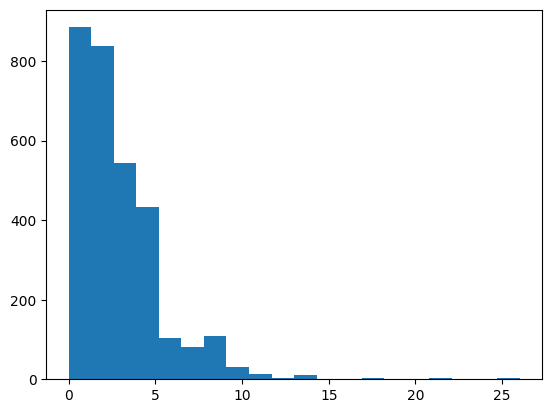

In [161]:
#taking a look at the building levels in the 100000 building sample
plt.hist(gdf['building:levels'].astype(float), bins=20)
plt.show()

In [78]:
#if one wants to store a gdf, this is how you do it
#gdf.to_file('datafram.shp')

/tmp/ipykernel_2616/2662106380.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('datafram.shp')


In [84]:
#learning new stuff about the projection
gdf.crs

<Derived Projected CRS: +proj=utm +zone=33 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [85]:
#testing filtering out the Stockholm region using the cx-function
#gdf_s = gdf.cx[672205:6579860, 676862:6577873]

In [7]:
i = 200000
while i < len(buildinghandler.buildings):
    dfx = pd.DataFrame(buildinghandler.buildings[(i-200000):min([i, len(buildinghandler.buildings)-1])])
    gdfx = geopandas.GeoDataFrame(dfx, geometry='geometry')
    gdfx = gdfx.set_crs("EPSG:4326")
    gdfx = ox.project_gdf(gdfx)
    gdfx = gdfx.cx[672236:676942, 6577855:6579891]
    #gdfx = gdfx.dropna(subset=['building:levels'])
    gdfx = gdfx[['w_id', 'geometry', 'building:levels']]
    if i < 200001:
        meta = gdfx
    else:
        meta = pd.concat([meta, gdfx])
    print(meta.shape)
    i += 200000

(345, 3)
(425, 3)
(450, 3)
(480, 3)
(520, 3)
(526, 3)
(540, 3)
(584, 3)
(1127, 3)
(1151, 3)


In [8]:
levels = meta.dropna(subset=['building:levels'])
levels.shape

(119, 3)

In [9]:
nolevel = meta.loc[~meta.index.isin(meta.dropna(subset=['building:levels']).index)]
nolevel.shape

(1032, 3)

In [10]:
y = levels['building:levels'].astype(float)
x = levels.area

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(
    x, y, train_size=60, random_state=42, shuffle=True
)

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
model = LinearRegression()

In [24]:
import numpy as np
model.fit(np.array(X_train).reshape(-1,1), y_train)

LinearRegression()

In [25]:
from sklearn.metrics import mean_squared_error
import math
predict_y = model.predict(np.array(X_test).reshape(-1,1))
rmse = math.sqrt(mean_squared_error(y_test,predict_y))
rmse

1.874954192307476

In [26]:
#computing scatter indexs
rmse / y.mean() * 100
#and it is very high - the model is not a good one

65.04943116168795

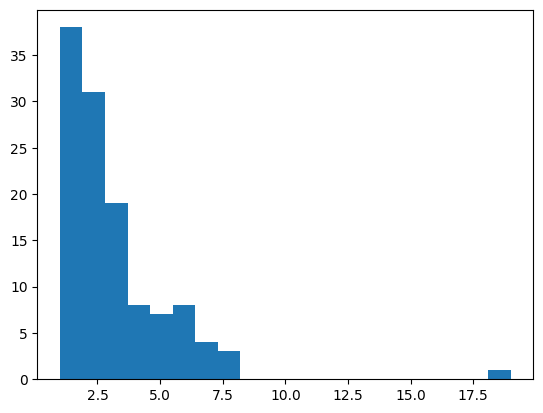

In [27]:
plt.hist(y, bins=20)
plt.show()

Text(0.5, 0, 'area at groundlevel')

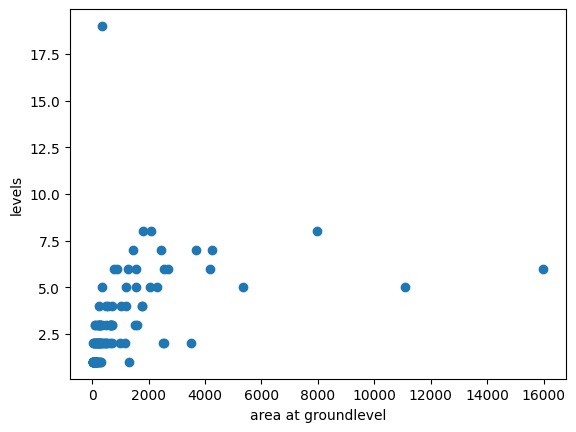

In [28]:
#scatter plotting to inspect the correlation between area and levels
plt.scatter(x, y)
plt.ylabel('levels')
plt.xlabel('area at groundlevel')

In [29]:
#for now we'll just go with the average levels for the buildings without level data
y.mean()

2.8823529411764706

In [ ]:
nolevel['building:levels'] = 3

In [31]:
nolevel['building:levels']

106       3
199       3
201       3
1282      3
1288      3
         ..
178074    3
193536    3
193537    3
193538    3
196150    3
Name: building:levels, Length: 1032, dtype: int64

In [ ]:
nolevel['real_level'] = 'no'

In [ ]:
levels['real_level'] = 'yes'

In [34]:
soder = pd.concat([nolevel, levels])
soder

,w_id,geometry,building:levels,real_level
106,29739502,"MULTIPOLYGON (((675044.798 6578075.038, 675058...",3,no
199,34785030,"MULTIPOLYGON (((673689.522 6579543.223, 673693...",3,no
201,34796328,"MULTIPOLYGON (((672820.749 6579317.258, 672827...",3,no
1282,53090592,"MULTIPOLYGON (((673418.451 6578924.569, 673427...",3,no
1288,53126832,"MULTIPOLYGON (((674289.096 6578234.232, 674303...",3,no
...,...,...,...,...
105246,1772940932,"MULTIPOLYGON (((672252.625 6579577.765, 672258...",1,yes
34145,27146421,"MULTIPOLYGON (((673817.440 6579496.233, 673821...",3,yes
106233,2131687362,"MULTIPOLYGON (((674117.309 6579728.275, 674117...",1,yes
106235,2131687366,"MULTIPOLYGON (((675160.456 6579479.807, 675169...",2,yes


In [35]:
soder['floorarea'] = soder.area * soder['building:levels'].astype(float)
#metal = metal[meta['building:levels'].str.contains('[A-Za-z]') == False]

In [36]:
soder['floorarea']

106       30399.832350
199        4282.965916
201        1099.050335
1282        233.347780
1288       4064.620119
              ...     
105246       17.882016
34145      1985.671017
106233       43.533824
106235      251.379143
188693       30.875209
Name: floorarea, Length: 1151, dtype: float64

In [37]:
#multiplying floor area with figure from Antti's model, using climate zone 5 for Stockholm
soder['kWh/a'] = soder['floorarea'] * 159.993

In [38]:
#using this article https://www.sei.org/publications/swedish-heat-energy-system-new-tensions-and-lock-ins-after-a-successful-transition/#:~:text=Fossil%20fuel%20energy%20has%20been,demand%20for%20heating%20in%20buildings.
#to calculate an estimate of the energy mix and it's co2-emissions using Antti's model
co2 = 0.5*0.195 + 0.25*0.104 + 0.08*0.255 + 0.08*0.354 + 0.09*0.403
co2

0.20848999999999998

In [39]:
#multiplying kWh with co2/kWh for estimate of co2-emissions
soder['yearly-co2'] = soder['kWh/a'] * co2

In [40]:
soder = soder.rename(columns={'building:levels':'levels', 'yearly-co2':'co2/yr'})

In [41]:
soder.head()

,w_id,geometry,levels,real_level,floorarea,kWh/a,co2/yr
106,29739502,"MULTIPOLYGON (((675044.798 6578075.038, 675058...",3,no,30399.832350,4.863760e+06,1.014045e+06
199,34785030,"MULTIPOLYGON (((673689.522 6579543.223, 673693...",3,no,4282.965916,6.852446e+05,1.428666e+05
201,34796328,"MULTIPOLYGON (((672820.749 6579317.258, 672827...",3,no,1099.050335,1.758404e+05,3.666096e+04
1282,53090592,"MULTIPOLYGON (((673418.451 6578924.569, 673427...",3,no,233.347780,3.733401e+04,7.783768e+03
1288,53126832,"MULTIPOLYGON (((674289.096 6578234.232, 674303...",3,no,4064.620119,6.503108e+05,1.355833e+05


In [42]:
soder.to_file('sodermalm-all.shp')

In [29]:
how_to_read = geopandas.read_file('sodermalm.shp')
how_to_read.head()

,w_id,levels,floorarea,kWh/a,co2/a,geometry
0,29741604,4,11743.984416,1.878955e+06,391743.390228,"POLYGON ((675282.055 6577525.008, 675301.606 6..."
1,29752940,4,2031.588532,3.250399e+05,67767.577923,"POLYGON ((672911.430 6576548.124, 672922.732 6..."
2,47971704,2,4490.550194,7.184566e+05,149791.015938,"POLYGON ((678820.355 6571576.675, 678839.388 6..."
3,48029436,2,672.347392,1.075709e+05,22427.451988,"POLYGON ((679299.694 6574068.135, 679308.462 6..."
4,48780448,1,14555.442774,2.328769e+06,485525.039569,"POLYGON ((673941.779 6572849.976, 674217.168 6..."
